# **Object Detection of a image with Faster R-CNN + Inception_Resnet_V2**

Loading Packages 

In [22]:
import tensorflow as tf
import tensorflow_hub as hub
# For downloading the image.
import matplotlib.pyplot as plt
import tempfile
from six.moves.urllib.request import urlopen
from six import BytesIO

# For drawing onto the image.
import numpy as np
from PIL import Image
from PIL import ImageColor
from PIL import ImageDraw
from PIL import ImageFont
from PIL import ImageOps

# For measuring the inference time.
import time

 From Tensorflow Hub we have taken the model **faster_rcnn/openimages_v4/inception_resnet_v2** which is pre-trained on Openimages V4.
 
 The link of the model is given bellow:
 https://tfhub.dev/google/faster_rcnn/openimages_v4/inception_resnet_v2/1

In [23]:
model_handle="https://tfhub.dev/google/faster_rcnn/openimages_v4/inception_resnet_v2/1"

Choose a default signature for object detection

In [24]:
detector=hub.load(model_handle).signatures["default"]

INFO:tensorflow:Saver not created because there are no variables in the graph to restore


INFO:tensorflow:Saver not created because there are no variables in the graph to restore


# *For Displaying the Image and resize it*

In [25]:
def display_image(image):
    """
    Displays an image inside the notebook.
    This is used by download_and_resize_image()
    """
    fig = plt.figure(figsize=(20, 15))
    plt.grid(False)
    plt.imshow(image)
    
def download_and_resize_image(url, new_width=256, new_height=256,
                              display=False):
  _, filename = tempfile.mkstemp(suffix=".jpg")
  response = urlopen(url)
  image_data = response.read()
  image_data = BytesIO(image_data)
  pil_image = Image.open(image_data)
  pil_image = ImageOps.fit(pil_image, (new_width, new_height), Image.ANTIALIAS)
  pil_image_rgb = pil_image.convert("RGB")
  pil_image_rgb.save(filename, format="JPEG", quality=90)
  print("Image downloaded to %s." % filename)
  if display:
    display_image(pil_image)
  return filename

# Preprocessing:  Loading the Image and Resize it

Please note that if you **copy image link** from google photes then first **copy the image link to another new tab** then from there **copy image link** the image and paste it in the **image url** 

Image downloaded to /tmp/tmpjuh739rp.jpg.


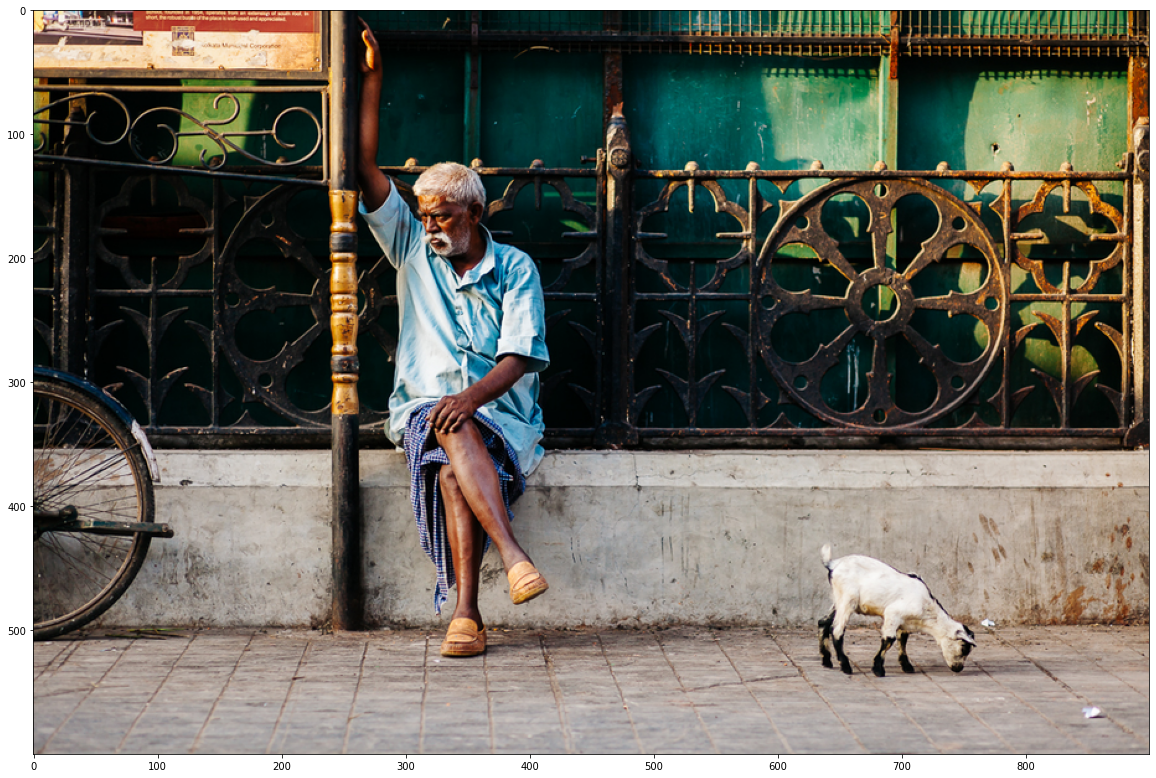

In [33]:
image_url="http://shooterfiles.com/wp-content/uploads/2015/04/Kolkata-Shooter-Files-2.jpg"
downloaded_image_path = download_and_resize_image(image_url, 900,600, True)

# **Drawing Bounding Boxes**

There are two functions one is **draw_boxes** and another is **draw_bounding_box_on_image**. We can use **draw_boxes** to do this. It will use **draw_bounding_box_on_image** to draw the bounding boxes

In [27]:
def draw_bounding_box_on_image(image,
                               ymin,
                               xmin,
                               ymax,
                               xmax,
                               color,
                               font,
                               thickness=4,
                               display_str_list=()):

    """
    Adds a bounding box to an image.
    
    Args:
        image -- the image object
        ymin -- bounding box coordinate
        xmin -- bounding box coordinate
        ymax -- bounding box coordinate
        xmax -- bounding box coordinate
        color -- color for the bounding box edges
        font -- font for class label
        thickness -- edge thickness of the bounding box
        display_str_list -- class labels for each object detected
    
    
    Returns:
        No return.  The function modifies the `image` argument 
                    that gets passed into this function
    
    """
    draw = ImageDraw.Draw(image)
    im_width, im_height = image.size
    
    # scale the bounding box coordinates to the height and width of the image
    (left, right, top, bottom) = (xmin * im_width, xmax * im_width,
                                ymin * im_height, ymax * im_height)
    
    # define the four edges of the detection box
    draw.line([(left, top), (left, bottom), (right, bottom), (right, top),
             (left, top)],
            width=thickness,
            fill=color)

    # If the total height of the display strings added to the top of the bounding
    # box exceeds the top of the image, stack the strings below the bounding box
    # instead of above.
    display_str_heights = [font.getsize(ds)[1] for ds in display_str_list]
    # Each display_str has a top and bottom margin of 0.05x.
    total_display_str_height = (1 + 2 * 0.05) * sum(display_str_heights)

    if top > total_display_str_height:
        text_bottom = top
    else:
        text_bottom = top + total_display_str_height
        
    # Reverse list and print from bottom to top.
    for display_str in display_str_list[::-1]:
        text_width, text_height = font.getsize(display_str)
        margin = np.ceil(0.05 * text_height)
        draw.rectangle([(left, text_bottom - text_height - 2 * margin),
                        (left + text_width, text_bottom)],
                       fill=color)
        draw.text((left + margin, text_bottom - text_height - margin),
                  display_str,
                  fill="black",
                  font=font)
        text_bottom -= text_height - 2 * margin


def draw_boxes(image, boxes, class_names, scores, max_boxes=10, min_score=0.1):
    """
    Overlay labeled boxes on an image with formatted scores and label names.
    
    Args:
        image -- the image as a numpy array
        boxes -- list of detection boxes
        class_names -- list of classes for each detected object
        scores -- numbers showing the model's confidence in detecting that object
        max_boxes -- maximum detection boxes to overlay on the image (default is 10)
        min_score -- minimum score required to display a bounding box
    
    Returns:
        image -- the image after detection boxes and classes are overlaid on the original image.
    """
    colors = list(ImageColor.colormap.values())

    try:
        font = ImageFont.truetype("/usr/share/fonts/truetype/liberation/LiberationSansNarrow-Regular.ttf",
                              25)
    except IOError:
        print("Font not found, using default font.")
        font = ImageFont.load_default()

    for i in range(min(boxes.shape[0], max_boxes)):
        
        # only display detection boxes that have the minimum score or higher
        if scores[i] >= min_score:
            ymin, xmin, ymax, xmax = tuple(boxes[i])
            display_str = "{}: {}%".format(class_names[i].decode("ascii"),
                                         int(100 * scores[i]))
            color = colors[hash(class_names[i]) % len(colors)]
            image_pil = Image.fromarray(np.uint8(image)).convert("RGB")

            # draw one bounding box and overlay the class labels onto the image
            draw_bounding_box_on_image(image_pil,
                                       ymin,
                                       xmin,
                                       ymax,
                                       xmax,
                                       color,
                                       font,
                                       display_str_list=[display_str])
            np.copyto(image, np.array(image_pil))
        
    return image

#### We need to store the image in the tensor (First line)
The variable **img** is a tensor containing the image with three channels because of RGB

In [34]:
img=tf.io.read_file(downloaded_image_path)
img=tf.image.decode_jpeg(img,channels=3)

Now convert the image tensor to 4D tensor of type float32, **so why we do that?** The model is able to take batches of images, plus there have three channels each so we need the additional dimension for storing the images.
**Suppose we have 20 images of height 200 and width of 100 so for that we require a tensor of 4D to store the images, because 20 times 200 times 100 times 3 channels**

In [35]:
convert_img=tf.image.convert_image_dtype(img,tf.float32)[tf.newaxis,...]

Detector is the model which we load from the tensorflow hub 
We will to store the results in a variable and save the results in a dictionary

In [36]:
# run inference using the model
start_time = time.time()
result = detector(convert_img)
end_time = time.time()
result = {key:value.numpy() for key,value in result.items()}

# Print results

In [37]:
print("Found %d objects." % len(result["detection_scores"]))
print("Inference time: ", end_time-start_time)

Found 100 objects.
Inference time:  1.2223398685455322


## Draw predicted boxes over the image and display the image

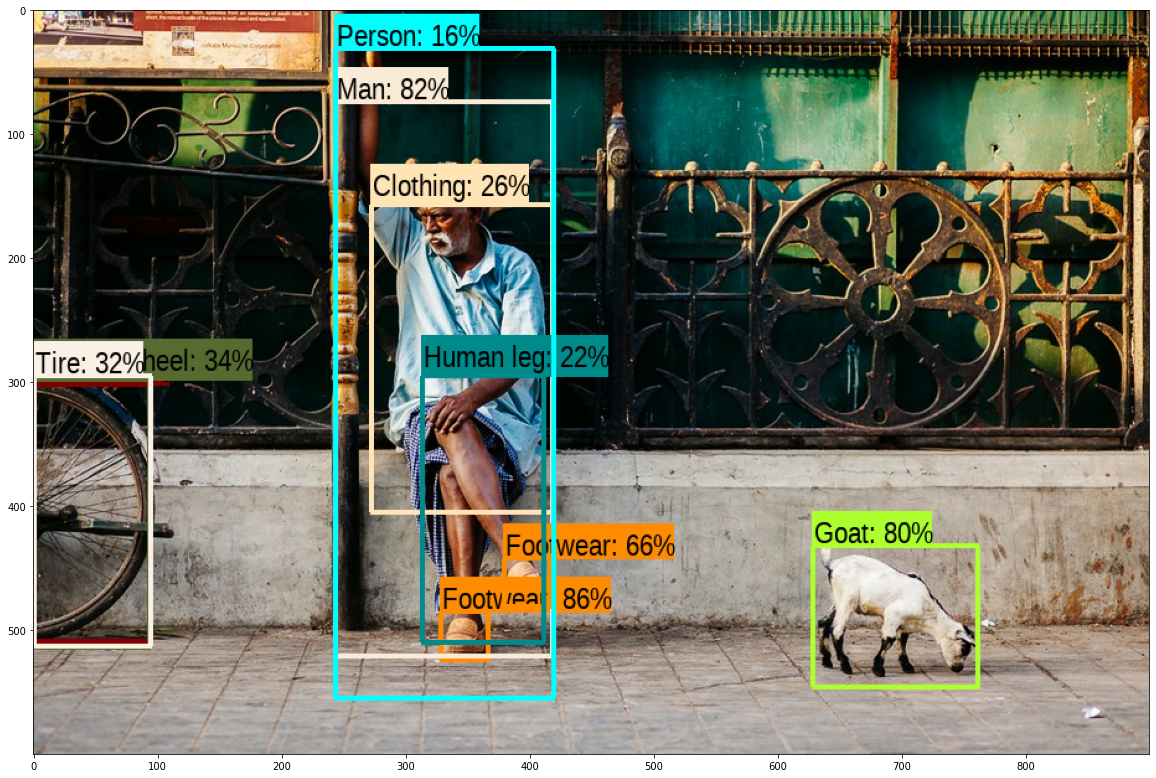

In [38]:
image_with_boxes = draw_boxes(
      img.numpy(), result["detection_boxes"],
      result["detection_class_entities"], result["detection_scores"])
display_image(image_with_boxes)